### Drone Delivery using DQN

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pickle
from collections import defaultdict
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
class DroneDeliveryEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, stochastic=False):
        super(DroneDeliveryEnv, self).__init__()

        self.grid_size = (6, 6)
        self.start_pos = [1, 1]
        self.package_pickup = [2, 4]
        self.delivery_location = [6, 6]
        self.no_fly_zones = {(2, 5), (3, 4), (5, 2), (6, 3)}
        self.stochastic = stochastic
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_size[0]),
            spaces.Discrete(self.grid_size[1]),
            spaces.Discrete(2)
        ))
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.position = self.start_pos[:]
        self.carrying_package = False
        self.steps = 0
        return self._get_observation(), {}

    def _get_observation(self):
        return (self.position[0], self.position[1], int(self.carrying_package))

    def step(self, action, render_mode=False):
        reward = -1
        terminated = False
        prev_position = self.position[:]
        prev_carrying = self.carrying_package

        if self.stochastic and np.random.rand() < 0.1:
            action = np.random.choice([0, 1, 2, 3])

        new_position = self.position[:]

        if action == 0:
            new_position[0] -= 1
        elif action == 1:
            new_position[0] += 1
        elif action == 2:
            new_position[1] -= 1
        elif action == 3:
            new_position[1] += 1

        if 1 <= new_position[0] <= self.grid_size[0] and 1 <= new_position[1] <= self.grid_size[1]:
            self.position = new_position[:]

        if tuple(self.position) in self.no_fly_zones:
            self.position = prev_position
            reward = -100
            terminated = True

        if action == 4:
            if self.position == self.package_pickup and not self.carrying_package:
                self.carrying_package = True
                reward = 50
            else:
                reward -= 10

        elif action == 5:
            if self.position == self.delivery_location and self.carrying_package:
                self.carrying_package = False
                reward = 250
                terminated = True
            else:
                reward -= 10

        new_state = self._get_observation()

        self.steps += 1

        if render_mode:
            self.render()

        return new_state, reward, terminated, False, {}

    def render(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(0.5, 6.5)
        ax.set_ylim(0.5, 6.5)

        def add_image(image_path, position, zoom=0.6):
            img = plt.imread(image_path)
            imagebox = OffsetImage(img, zoom=zoom)
            centered_position = (position[1], 7 - position[0])
            ab = AnnotationBbox(imagebox, centered_position, frameon=False)
            ax.add_artist(ab)

        for nfz in self.no_fly_zones:
            add_image("images/no-fly.png", nfz, zoom=0.1)

        if self.position != self.package_pickup and not self.carrying_package:
            add_image("images/pick-up.png", self.package_pickup, zoom=0.3)

        add_image("images/drop-off.png", self.delivery_location, zoom=0.1)

        if self.position == self.package_pickup and not self.carrying_package:
            add_image("images/at-pickup.png", self.position, zoom=0.1)
        elif self.carrying_package:
            add_image("images/carrying.png", self.position, zoom=0.2)
        else:
            add_image("images/drone.png", self.position, zoom=0.1)

        ax.set_xticks(np.arange(1, 7))
        ax.set_yticks(np.arange(1, 7))
        ax.set_xticklabels(np.arange(1, 7))
        ax.set_yticklabels(np.arange(6, 0, -1))

        ax.set_xticks(np.arange(0.5, 6.5, 1), minor=True)
        ax.set_yticks(np.arange(0.5, 6.5, 1), minor=True)
        ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)

        plt.title(f"Drone Position: {self.position}, Carrying: {self.carrying_package}")
        plt.show()

In [ ]:
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, transition):
        self.buffer.append(transition)
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 6)
        )

    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, env, memory_capacity=20000, batch_size=64,
                 gamma=0.99, lr=0.0005, target_update=90,
                 epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.9996):
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.target_update = target_update
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.policy_net = DQN().to(self.device)
        self.target_net = DQN().to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.memory = ReplayMemory(memory_capacity)
        self.steps_done = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            return self.policy_net(state).argmax().item()

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.bool, device=self.device).unsqueeze(1)

        q_values = self.policy_net(states).gather(1, actions)
        next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1).detach()
        targets = rewards + self.gamma * next_q_values * (~dones)
        loss = nn.functional.mse_loss(q_values, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, episodes=4000, max_steps=50, model_path="a2_part_2_dqn_gridworld_shrutili_omjagatr.pth"):
        best_reward = float('-inf')
        rewards = []
        for ep in range(episodes):
            state, _ = self.env.reset()
            state = np.array(state, dtype=np.float32)
            total_reward = 0

            for _ in range(max_steps):
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                next_state = np.array(next_state, dtype=np.float32)
                self.memory.push((state, action, reward, next_state, done))
                state = next_state
                total_reward += reward
                self.optimize_model()
                if done:
                    break

            rewards.append(total_reward)
            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

            if ep % self.target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            if total_reward > best_reward:
                best_reward = total_reward
                self.save_model(model_path)

            if ep % 100 == 0:
                print(f"Episode {ep}, Total reward: {total_reward}, Epsilon: {self.epsilon:.3f}")
        return rewards

    def save_model(self, path):
        torch.save({
            'model_state_dict': self.policy_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, path)

    def load_model(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.policy_net.load_state_dict(checkpoint['model_state_dict'])
        self.target_net.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    def evaluate(self, episodes=10, max_steps=50, render_first=True):
        self.policy_net.eval()
        rewards = []
        for ep in range(episodes):
            state, _ = self.env.reset()
            state = np.array(state, dtype=np.float32)
            total_reward = 0
            for _ in range(max_steps):
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
                with torch.no_grad():
                    action = self.policy_net(state_tensor).argmax().item()
                next_state, reward, done, _, _ = self.env.step(action)

                if render_first and ep == 0:
                    print(f"Step: State={state}, Action={action}, Reward={reward}, Next={next_state}")
                    self.env.render()

                state = np.array(next_state, dtype=np.float32)
                total_reward += reward
                if done:
                    break
            rewards.append(total_reward)
        return rewards

In [5]:
class PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.4):
        self.capacity = capacity
        self.buffer = []
        self.priorities = []
        self.alpha = alpha
        self.position = 0

    def push(self, transition, td_error=1.0):
        priority = (abs(td_error) + 1e-6) ** self.alpha
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
            self.priorities.append(priority)
        else:
            self.buffer[self.position] = transition
            self.priorities[self.position] = priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities)
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[i] for i in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        return samples, indices, torch.tensor(weights, dtype=torch.float32)

    def update_priorities(self, indices, td_errors):
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = (abs(td_error) + 1e-6) ** self.alpha

    def __len__(self):
        return len(self.buffer)

class PERDQN(nn.Module):
    def __init__(self):
        super(PERDQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 6)
        )

    def forward(self, x):
        return self.net(x)

class PERDQNAgent:
    def __init__(self, env, memory_capacity=20000, batch_size=64,
                 gamma=0.99, lr=0.0005, target_update=90,
                 epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.9996):
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.target_update = target_update
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.policy_net = PERDQN().to(self.device)
        self.target_net = PERDQN().to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.memory = PrioritizedReplayMemory(memory_capacity)
        self.beta = 0.4
        self.beta_increment = 1e-4
        self.alpha = 0.4
        self.steps_done = 0
        self.per_warmup_steps = 5000

    def select_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            return self.policy_net(state).argmax().item()

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        self.beta = min(1.0, self.beta + self.beta_increment)

        if self.steps_done < self.per_warmup_steps:
            batch = random.sample(self.memory.buffer, self.batch_size)
            indices = None
            weights = torch.ones(self.batch_size, 1).to(self.device)
        else:
            batch, indices, weights = self.memory.sample(self.batch_size, beta=self.beta)
            weights = weights.unsqueeze(1).to(self.device)

        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.from_numpy(np.array(states)).float().to(self.device)
        next_states = torch.from_numpy(np.array(next_states)).float().to(self.device)
        actions = torch.tensor(actions, dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(1)
        dones = torch.tensor(dones, dtype=torch.bool, device=self.device).unsqueeze(1)

        q_values = self.policy_net(states).gather(1, actions)
        next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1).detach()
        targets = rewards + self.gamma * next_q_values * (~dones)

        td_errors = targets - q_values
        loss = (weights * td_errors.pow(2)).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if indices is not None:
            with torch.no_grad():
                new_td_errors = td_errors.squeeze().abs().cpu().numpy()
            self.memory.update_priorities(indices, new_td_errors)

        self.steps_done += 1

    def train(self, episodes=4000, max_steps=50, model_path="a2_part_3_perdqn_gridworld_shrutili_omjagatr.pth"):
        best_reward = float('-inf')
        rewards = []
        best_q_values = None
        for ep in range(episodes):
            state, _ = self.env.reset()
            state = np.array(state, dtype=np.float32)
            total_reward = 0
            episode_qs = []

            for _ in range(max_steps):
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                next_state = np.array(next_state, dtype=np.float32)

                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
                    q_values = self.policy_net(state_tensor).squeeze()
                    episode_qs.append(q_values.cpu().numpy())

                with torch.no_grad():
                    next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(self.device)
                    q_val = self.policy_net(state_tensor)[0][action]
                    next_q_val = self.target_net(next_state_tensor).max(1)[0]
                    td_error = reward + self.gamma * next_q_val * (1 - int(done)) - q_val

                self.memory.push((state, action, reward, next_state, done), td_error.item())
                state = next_state
                total_reward += reward
                self.optimize_model()
                if done:
                    break

            rewards.append(total_reward)
            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

            if total_reward > best_reward and total_reward > 250:
                best_reward = total_reward
                self.save_model(model_path)

                #if episode_qs:
                    #final_q_values = episode_qs[-1]
                    #print(f"\nBest model updated at episode {ep}")
                    #print(f"Total reward: {total_reward}")
                    #print(f"Final Q-values (last state of episode): {np.round(final_q_values, 2)}")
                    #print(f"Max Q-value: {final_q_values.max():.2f} | Action: {final_q_values.argmax()}")
                #else:
                    #print(f"\nBest model updated at episode {ep}, but Q-values could not be captured.")

            if ep % self.target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            if ep % 100 == 0:
                print(f"Episode {ep}, Total reward: {total_reward}, Epsilon: {self.epsilon:.3f}")

        return rewards

    def save_model(self, path):
        torch.save({
            'model_state_dict': self.policy_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, path)

    def load_model(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.policy_net.load_state_dict(checkpoint['model_state_dict'])
        self.target_net.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    def evaluate(self, episodes=10, max_steps=50, render_first=True):
        self.policy_net.eval()
        rewards = []
        for ep in range(episodes):
            state, _ = self.env.reset()
            state = np.array(state, dtype=np.float32)
            total_reward = 0
            for _ in range(max_steps):
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
                with torch.no_grad():
                    action = self.policy_net(state_tensor).argmax().item()
                next_state, reward, done, _, _ = self.env.step(action)

                if render_first and ep == 0:
                    print(f"Step: State={state}, Action={action}, Reward={reward}, Next={next_state}")
                    self.env.render()

                state = np.array(next_state, dtype=np.float32)
                total_reward += reward
                if done:
                    break
            rewards.append(total_reward)
        return rewards

> Training DQN Agent

In [6]:
env = DroneDeliveryEnv(stochastic=False)
dqn_agent = DQNAgent(env)
rewards = dqn_agent.train()

Episode 0, Total reward: -260, Epsilon: 1.000


<ipython-input-3-5f4c92fe535c>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.tensor(states, dtype=torch.float32, device=self.device)


Episode 100, Total reward: -171, Epsilon: 0.960
Episode 200, Total reward: -226, Epsilon: 0.923
Episode 300, Total reward: -210, Epsilon: 0.887
Episode 400, Total reward: -213, Epsilon: 0.852
Episode 500, Total reward: -232, Epsilon: 0.818
Episode 600, Total reward: -145, Epsilon: 0.786
Episode 700, Total reward: -185, Epsilon: 0.755
Episode 800, Total reward: -199, Epsilon: 0.726
Episode 900, Total reward: -115, Epsilon: 0.697
Episode 1000, Total reward: -165, Epsilon: 0.670
Episode 1100, Total reward: -118, Epsilon: 0.644
Episode 1200, Total reward: -174, Epsilon: 0.618
Episode 1300, Total reward: -82, Epsilon: 0.594
Episode 1400, Total reward: -103, Epsilon: 0.571
Episode 1500, Total reward: -78, Epsilon: 0.549
Episode 1600, Total reward: -160, Epsilon: 0.527
Episode 1700, Total reward: -80, Epsilon: 0.506
Episode 1800, Total reward: -144, Epsilon: 0.486
Episode 1900, Total reward: -131, Epsilon: 0.467
Episode 2000, Total reward: -116, Epsilon: 0.449
Episode 2100, Total reward: -139

> Training Rewards per Episode and Epsilon Decay Graph

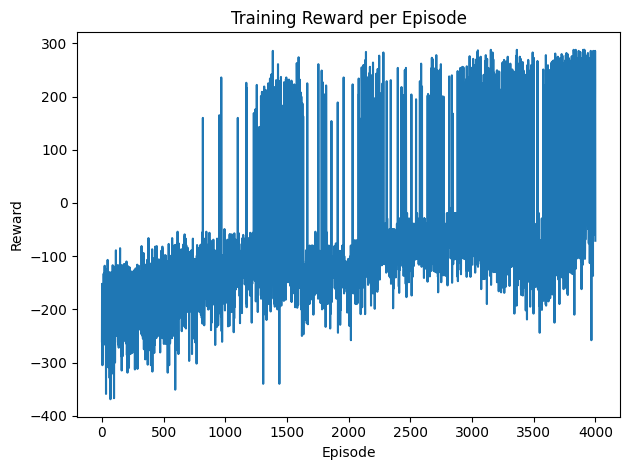

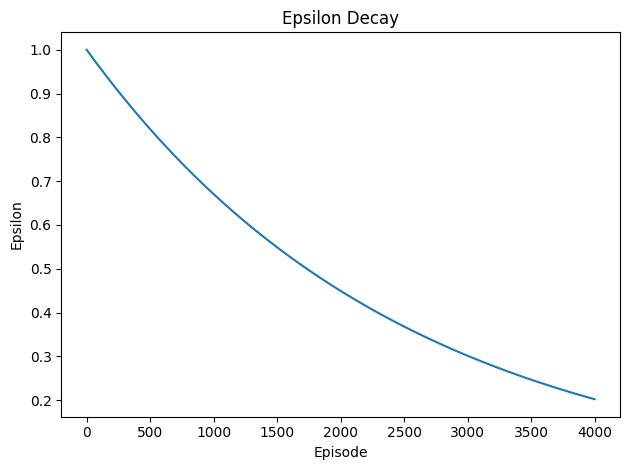

In [7]:
epsilons = [max(dqn_agent.epsilon_end, 1.0 * (dqn_agent.epsilon_decay ** i)) for i in range(len(rewards))]

plt.plot(rewards)
plt.title("Training Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.tight_layout()
plt.show()

plt.plot(epsilons)
plt.title("Epsilon Decay")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.tight_layout()
plt.show()

> Running the agent for 10 episodes, where
the agent chooses only greedy actions from the learnt policy with Total Reward per Episode for Evaluation
and 1 episode where the agent chooses only
greedy actions from the learned policy

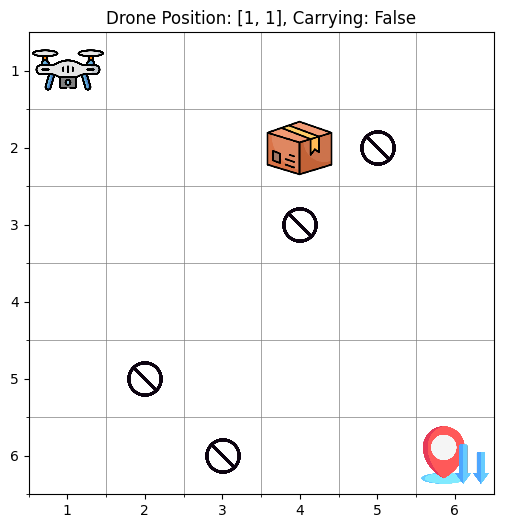

Step: State=[1. 1. 0.], Action=3, Reward=-1, Next=(1, 2, 0)


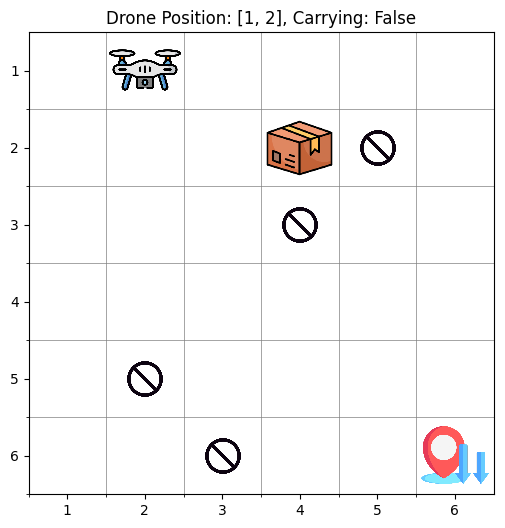

Step: State=[1. 2. 0.], Action=3, Reward=-1, Next=(1, 3, 0)


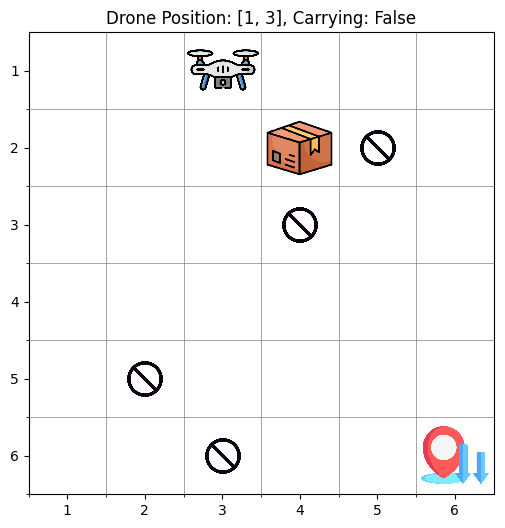

Step: State=[1. 3. 0.], Action=1, Reward=-1, Next=(2, 3, 0)


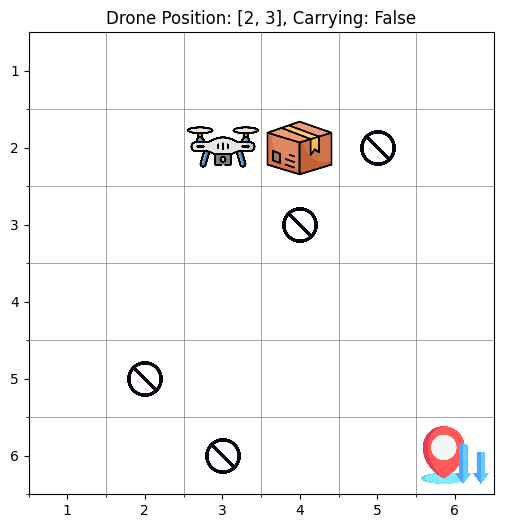

Step: State=[2. 3. 0.], Action=3, Reward=-1, Next=(2, 4, 0)


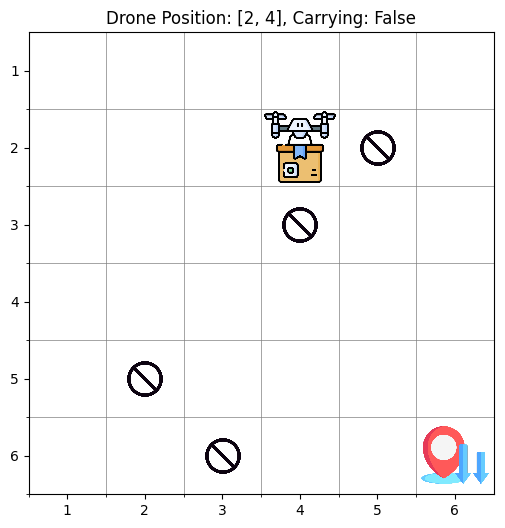

Step: State=[2. 4. 0.], Action=4, Reward=50, Next=(2, 4, 1)


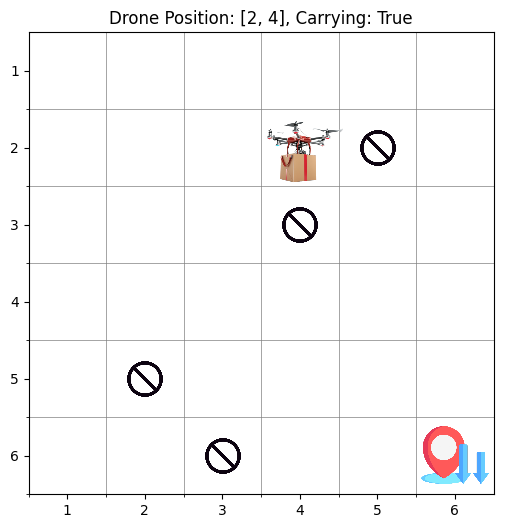

Step: State=[2. 4. 1.], Action=2, Reward=-1, Next=(2, 3, 1)


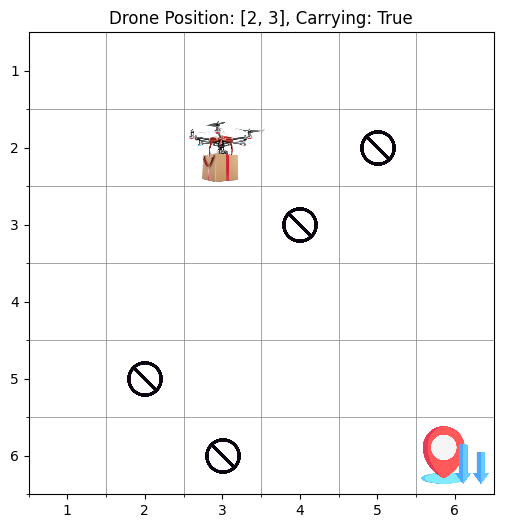

Step: State=[2. 3. 1.], Action=1, Reward=-1, Next=(3, 3, 1)


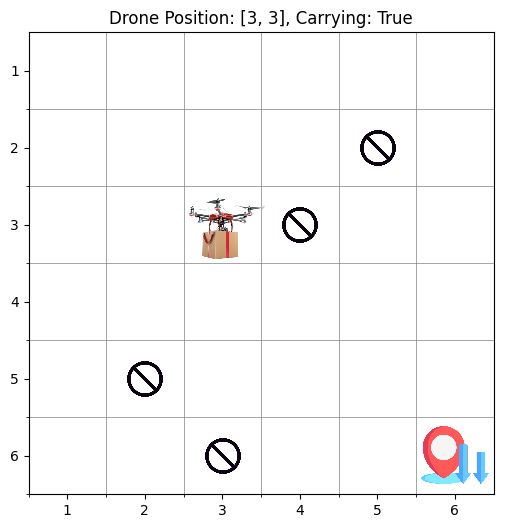

Step: State=[3. 3. 1.], Action=1, Reward=-1, Next=(4, 3, 1)


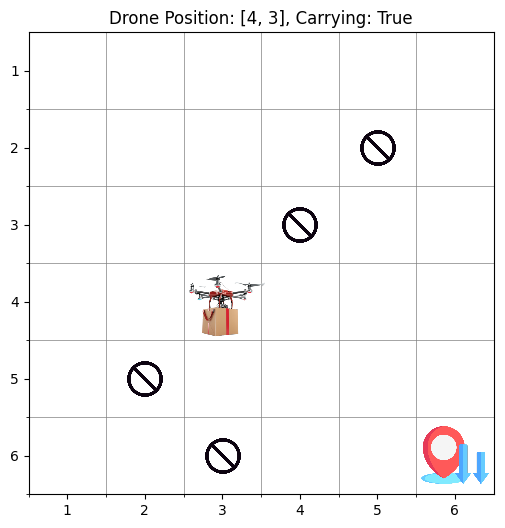

Step: State=[4. 3. 1.], Action=1, Reward=-1, Next=(5, 3, 1)


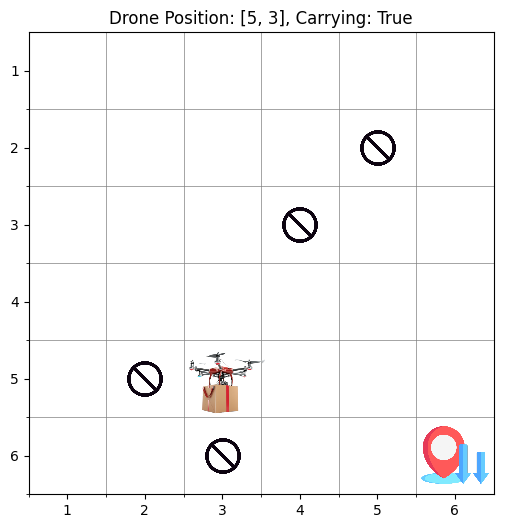

Step: State=[5. 3. 1.], Action=3, Reward=-1, Next=(5, 4, 1)


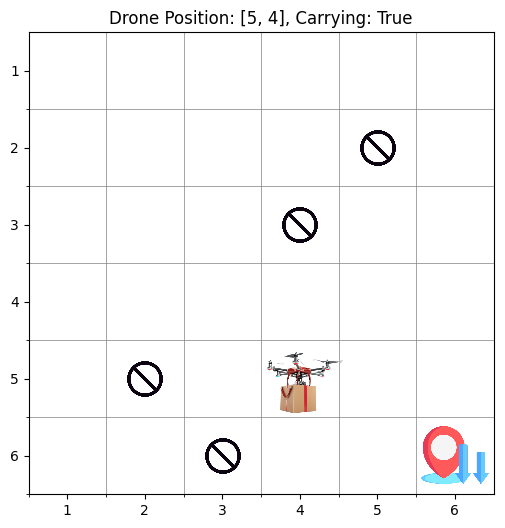

Step: State=[5. 4. 1.], Action=1, Reward=-1, Next=(6, 4, 1)


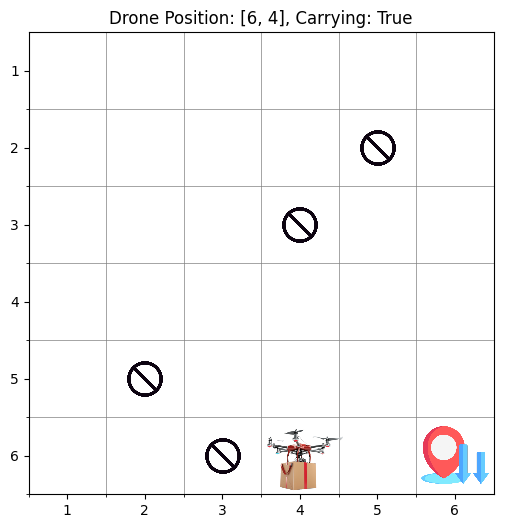

Step: State=[6. 4. 1.], Action=3, Reward=-1, Next=(6, 5, 1)


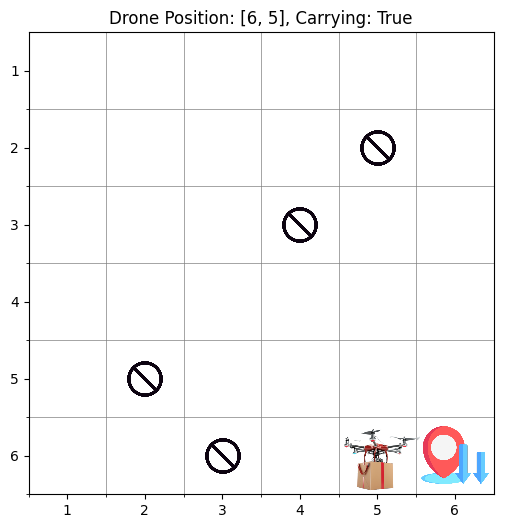

Step: State=[6. 5. 1.], Action=3, Reward=-1, Next=(6, 6, 1)


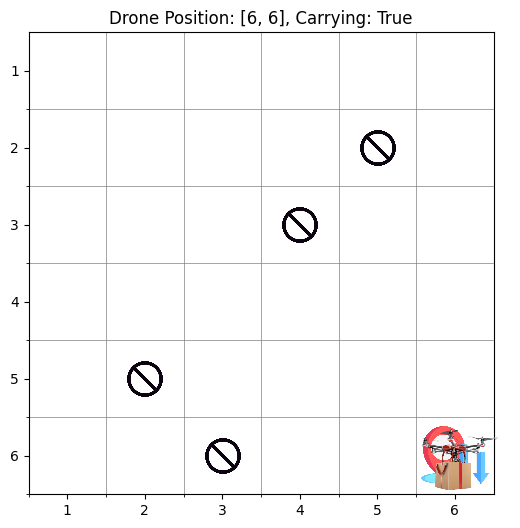

Step: State=[6. 6. 1.], Action=5, Reward=250, Next=(6, 6, 0)


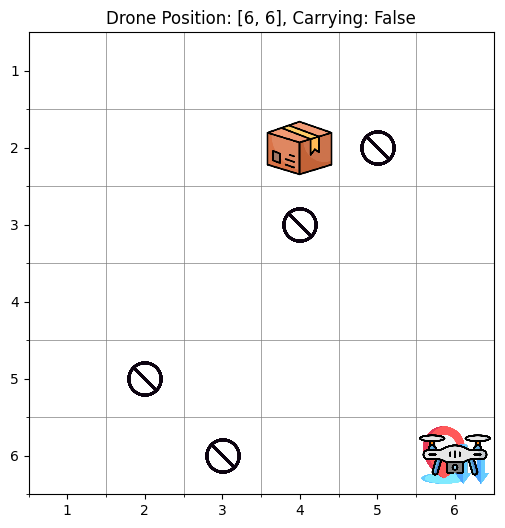

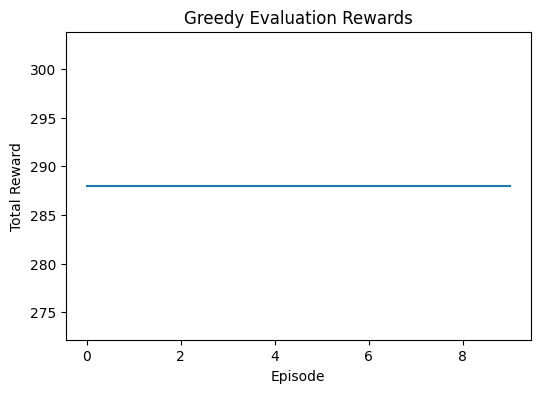

In [ ]:
dqn_agent.load_model("a2_part_2_dqn_gridworld_shrutili_omjagatr.pth")
state, _ = env.reset()
env.render()
greedy_rewards = dqn_agent.evaluate(render_first=True)
plt.figure(figsize=(6, 4))
plt.plot(greedy_rewards)
plt.title("Greedy Evaluation Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

> Training DQN with PER agent

In [8]:
env = DroneDeliveryEnv(stochastic=False)
perdqn_agent = PERDQNAgent(env)
per_rewards = perdqn_agent.train()

Episode 0, Total reward: -113, Epsilon: 1.000
Episode 100, Total reward: -140, Epsilon: 0.960
Episode 200, Total reward: -89, Epsilon: 0.923
Episode 300, Total reward: -59, Epsilon: 0.887
Episode 400, Total reward: -146, Epsilon: 0.852
Episode 500, Total reward: -135, Epsilon: 0.818
Episode 600, Total reward: -240, Epsilon: 0.786
Episode 700, Total reward: -70, Epsilon: 0.755
Episode 800, Total reward: -197, Epsilon: 0.726
Episode 900, Total reward: -184, Epsilon: 0.697
Episode 1000, Total reward: -54, Epsilon: 0.670
Episode 1100, Total reward: -59, Epsilon: 0.644
Episode 1200, Total reward: -205, Epsilon: 0.618
Episode 1300, Total reward: -109, Epsilon: 0.594
Episode 1400, Total reward: -109, Epsilon: 0.571
Episode 1500, Total reward: -79, Epsilon: 0.549
Episode 1600, Total reward: -82, Epsilon: 0.527
Episode 1700, Total reward: -79, Epsilon: 0.506
Episode 1800, Total reward: -149, Epsilon: 0.486
Episode 1900, Total reward: -49, Epsilon: 0.467
Episode 2000, Total reward: -74, Epsilon:

> Training Rewards per Episode and Epsilon Decay Graph

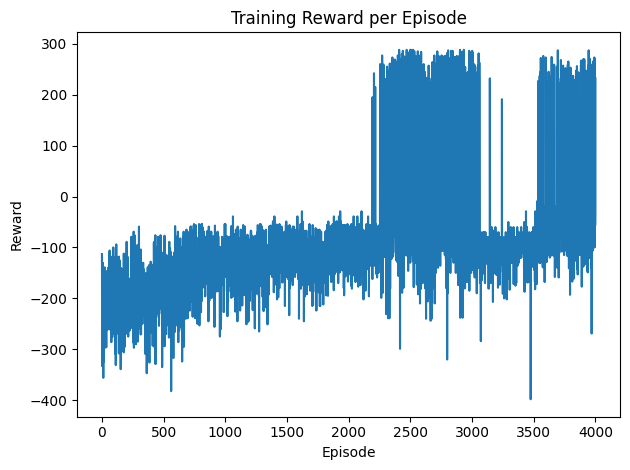

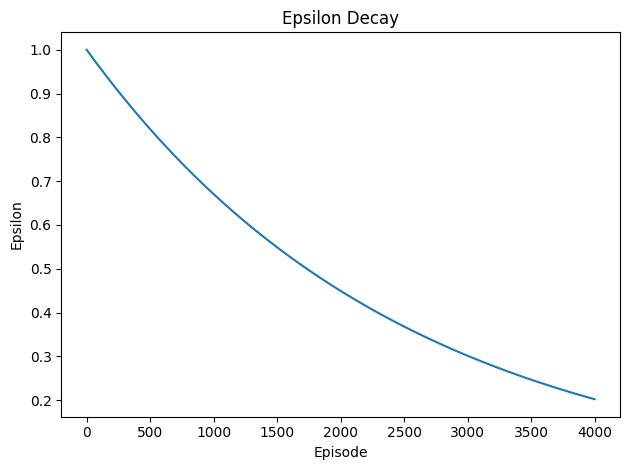

In [9]:
per_epsilons = [max(perdqn_agent.epsilon_end, 1.0 * (perdqn_agent.epsilon_decay ** i)) for i in range(len(per_rewards))]

plt.plot(per_rewards)
plt.title("Training Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.tight_layout()
plt.show()

plt.plot(per_epsilons)
plt.title("Epsilon Decay")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.tight_layout()
plt.show()

> Running the agent for 10 episodes, where
the agent chooses only greedy actions from the learnt policy with Total Reward per Episode for Evaluation
and 1 episode where the agent chooses only
greedy actions from the learned policy

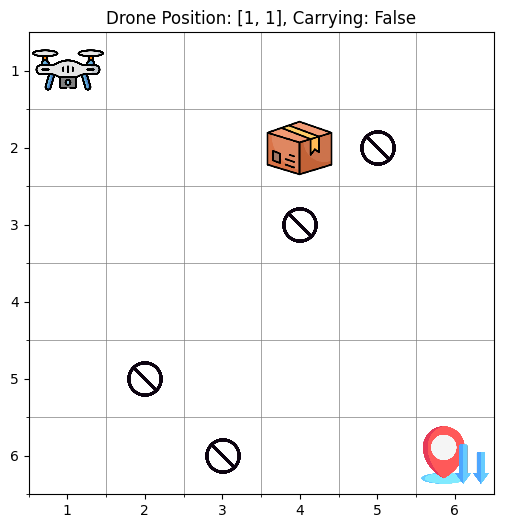

Step: State=[1. 1. 0.], Action=3, Reward=-1, Next=(1, 2, 0)


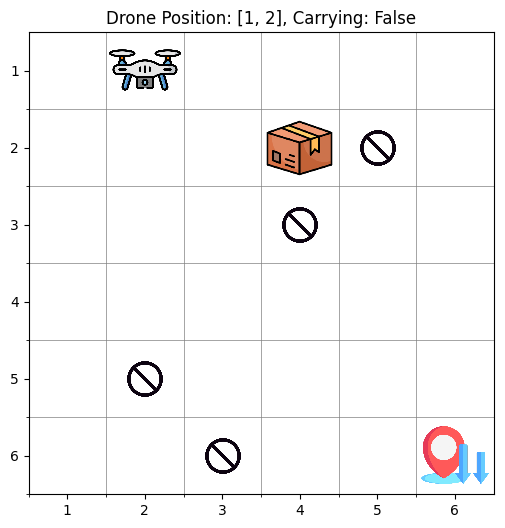

Step: State=[1. 2. 0.], Action=3, Reward=-1, Next=(1, 3, 0)


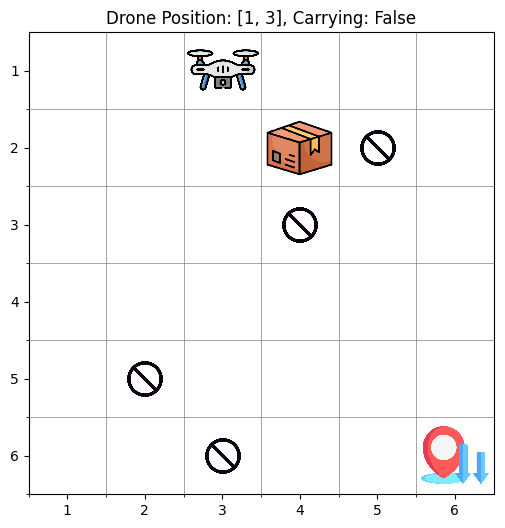

Step: State=[1. 3. 0.], Action=1, Reward=-1, Next=(2, 3, 0)


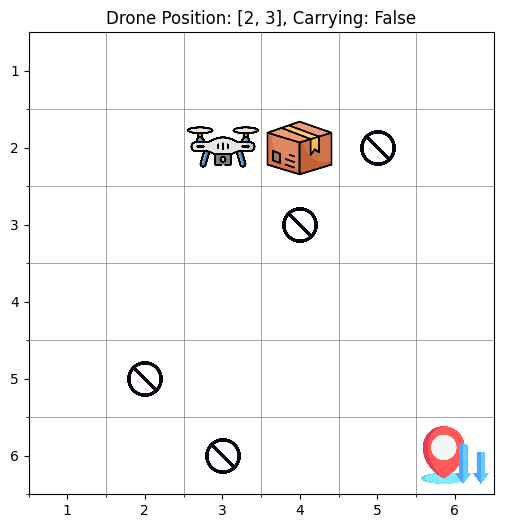

Step: State=[2. 3. 0.], Action=3, Reward=-1, Next=(2, 4, 0)


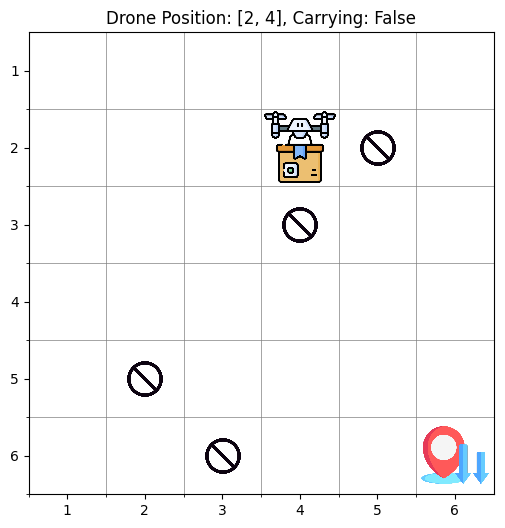

Step: State=[2. 4. 0.], Action=4, Reward=50, Next=(2, 4, 1)


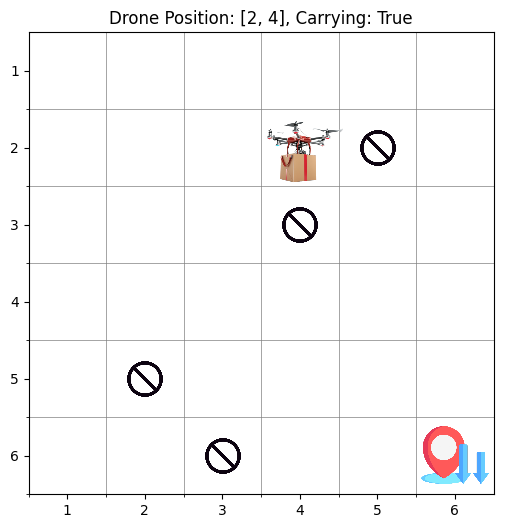

Step: State=[2. 4. 1.], Action=2, Reward=-1, Next=(2, 3, 1)


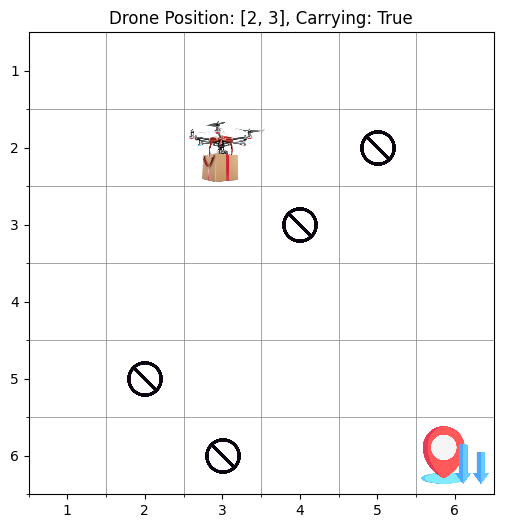

Step: State=[2. 3. 1.], Action=1, Reward=-1, Next=(3, 3, 1)


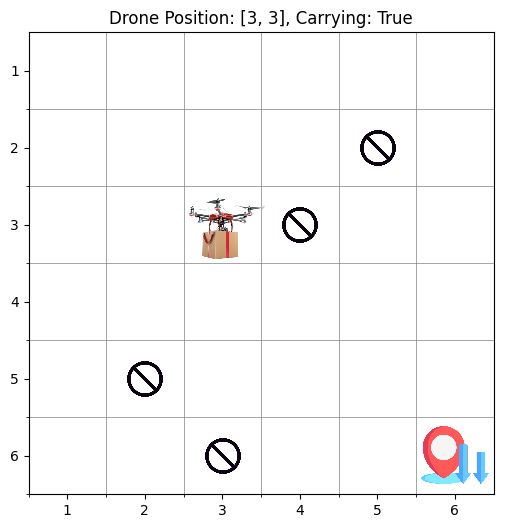

Step: State=[3. 3. 1.], Action=1, Reward=-1, Next=(4, 3, 1)


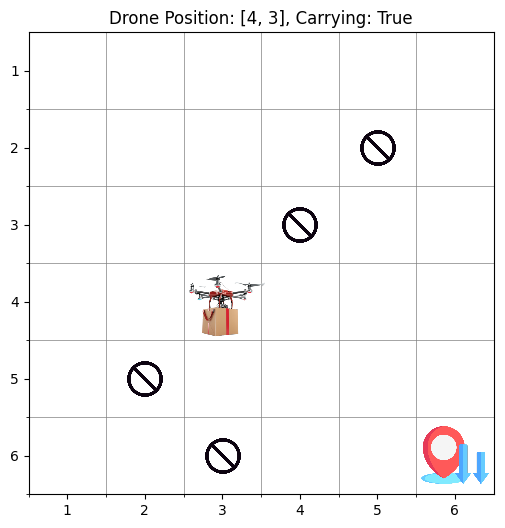

Step: State=[4. 3. 1.], Action=1, Reward=-1, Next=(5, 3, 1)


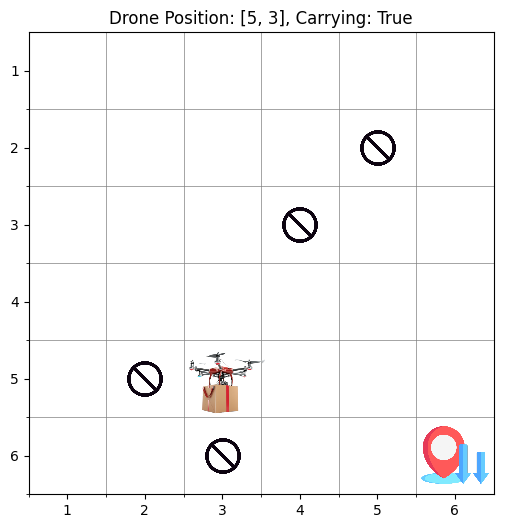

Step: State=[5. 3. 1.], Action=3, Reward=-1, Next=(5, 4, 1)


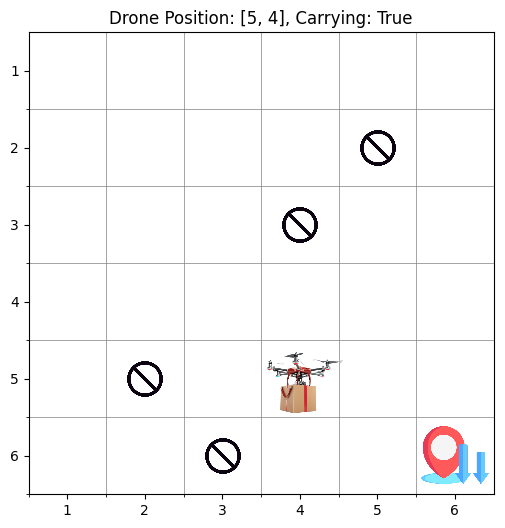

Step: State=[5. 4. 1.], Action=3, Reward=-1, Next=(5, 5, 1)


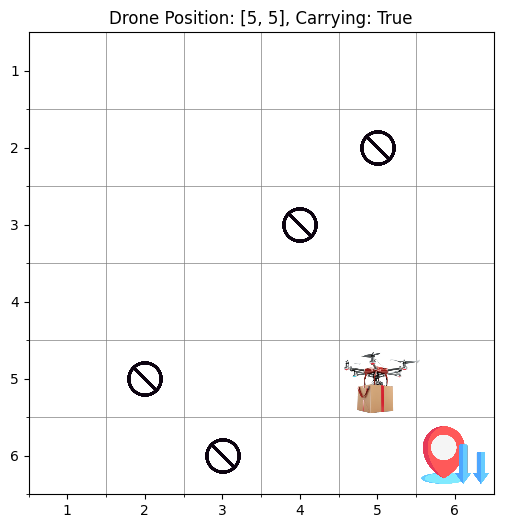

Step: State=[5. 5. 1.], Action=1, Reward=-1, Next=(6, 5, 1)


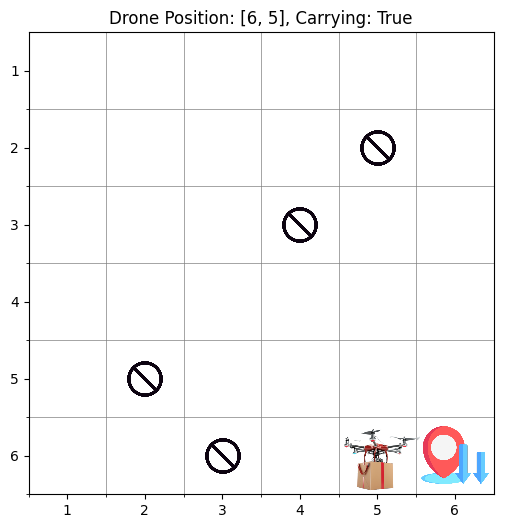

Step: State=[6. 5. 1.], Action=3, Reward=-1, Next=(6, 6, 1)


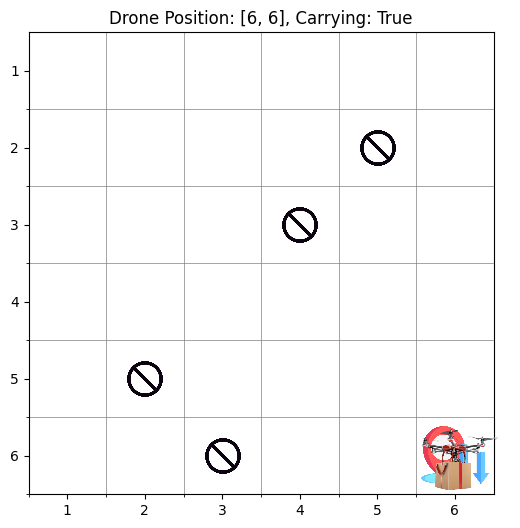

Step: State=[6. 6. 1.], Action=5, Reward=250, Next=(6, 6, 0)


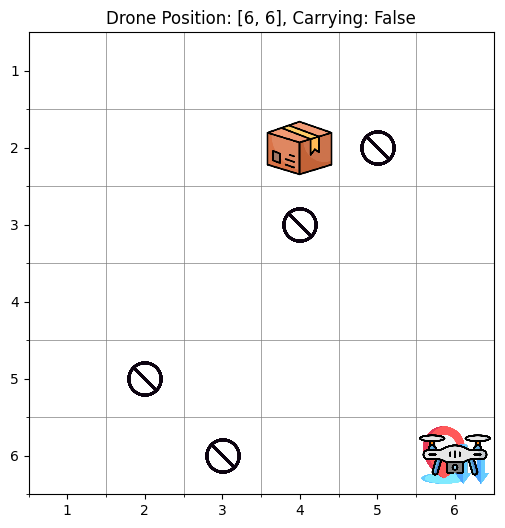

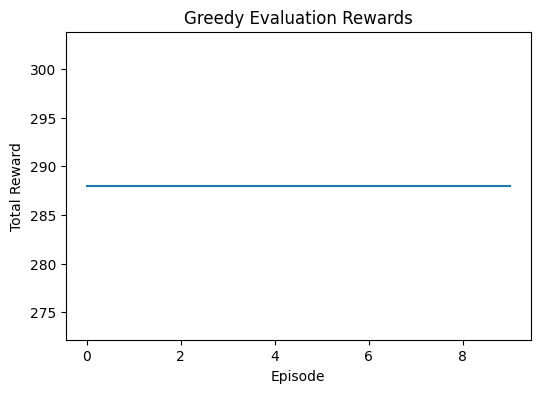

In [13]:
perdqn_agent.load_model("a2_part_3_perdqn_gridworld_shrutili_omjagatr.pth")
state, _ = env.reset()
env.render()
greedy_rewards = perdqn_agent.evaluate(render_first=True)
plt.figure(figsize=(6, 4))
plt.plot(greedy_rewards)
plt.title("Greedy Evaluation Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

> Comparison Plots

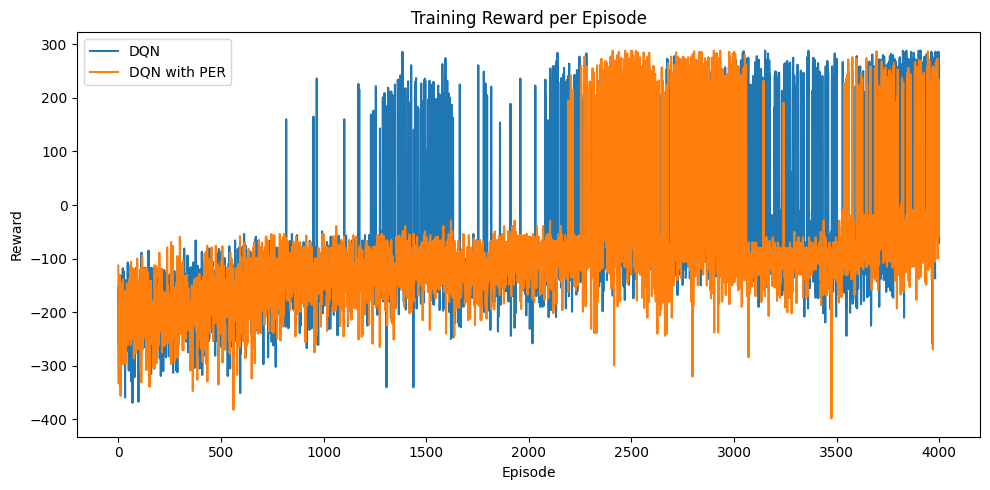

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(rewards, label='DQN')
plt.plot(per_rewards, label='DQN with PER')
plt.title("Training Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.tight_layout()
plt.show()

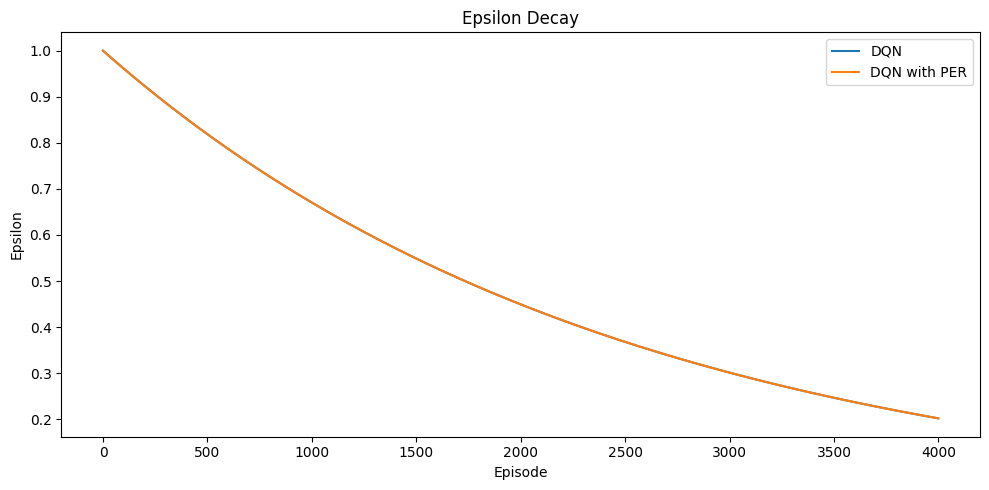

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(epsilons, label='DQN')
plt.plot(per_epsilons, label='DQN with PER')
plt.title("Epsilon Decay")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.legend()
plt.tight_layout()
plt.show()